In [1]:
import pandas as pd
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score,plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt
from pickle import load

Using TensorFlow backend.


In [2]:
def cm(target,prediction):
    result = pd.DataFrame({"Target": target, "Prediction": prediction})
    table = pd.crosstab(result["Prediction"],result["Target"])
    print("\n")
    print("sensitivity:",table.iloc[0,0]/table.iloc[:,0].sum())
    print("specificity:",table.iloc[1,1]/table.iloc[:,1].sum())
    print("accuracy:", (table.iloc[1,1] + table.iloc[0,0])/table.sum().sum())
    print("\n")
    return table
    
def roc(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 

    
def plot_roc(target, predicted):
    fp, tp, _ = roc_curve(target, predicted)
    plt.plot(fp, tp, label='ROC', linewidth=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--',  color='r',label='Chance')
    plt.legend(loc="lower right")

In [13]:
def blackbox(testfile = None):
    # assign X and y
    data = pd.read_csv(testfile)
    X = data.iloc[:,0:-1]
    y = data.iloc[:,-1]
    
    # NA clean
    categoricalColumn = []
    nonCategoricalColumn = []
    for col in X:
        if X[col].dtype == "object":
            categoricalColumn.append(col)
        else:
            nonCategoricalColumn.append(col)
    for col in nonCategoricalColumn:
        X[col].fillna((data[col].mean()), inplace = True)
        
    for col in categoricalColumn:
        X[col].fillna("U", inplace = True)
    
    # column selection
    selectedColumn = load(open('total.pkl','rb'))    
    
    # onehotencode
    X = pd.get_dummies(X[selectedColumn], drop_first = True)
    
    # import model
    model = load_model("HW2_Model.h5")
    
    # normalize
    scale = load(open('scaler.pkl','rb'))
    significantNon = load(open('significantNon.pkl','rb'))
    X[significantNon] = scale.transform(X[significantNon])
    X_train_norm_model = X
  
    
    # evaluate model
    evaluation = model.evaluate(X_train_norm_model, y)
    
    # get prediction and classfication
    prediction = model.predict(X_train_norm_model)
    classfication = model.predict_classes(X_train_norm_model)
    pc = []
    for i in range(len(classfication)):
        pc.append(classfication[i][0])
    realy = []
    for i in y:
        realy.append(i)
        
    # confusion matrix
    print("-------------------------------------------------------------")
    print("Confusion Matrix is:")
    print(cm(realy,pc))
    
    # get probability
    probability = []
    for i in prediction.tolist():
        probability.append(i[0])
        
    # ROC plot
    plot_roc(y.tolist(), probability)
    

C:\Users\zhong\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (328,336) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


39508/39508 [==============================] - 1s 17us/step
-------------------------------------------------------------
Confusion Matrix is:


sensitivity: 0.6601615454134658
specificity: 0.795609756097561
accuracy: 0.6742178799230536


Target          0     1
Prediction             
0           23375   838
1           12033  3262


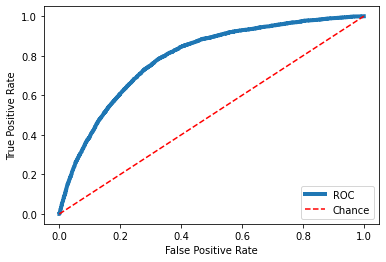

In [14]:
blackbox(testfile = "Data.csv")